# Notebook for working with and training models on VGGish embeddings
### In this notebook, we did the following


#### 1) Extracted VGGish embeddings from the audio samples in the crowd sourced english accent dataset which has already been prepared in the preprocessing notebook

#### 2) We labeled the VGGish embeddings

#### 3) we split the exctracted VGGish embeddings into train and validate data

### 4) We trained and evaluated the VGGish embeddings with a CNN, LSTM and MLP model

In [ ]:
pip install pydub

In [ ]:
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os
import pickle
import pydub

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from keras.src.layers.core.masking import Masking

In [ ]:
drive_path = "/content/drive/MyDrive/Accent Detection/"

# VGGish embedding extraction

+ To extract the MFCC features, we made use of a class we named prepare_vggish_speech_embeddings.
+ The class has 3 methods for extracting vggish ebeddings from a single audio, extracting from a single directory and extracting from a multiple classes as seen below

+ We mainly made use of the extract_speech_embeddings_for_multiple_classes methos to help us extract the VGGish ebeddings since the data was in multiple classes as designed in the preprocessing notebook~

In [ ]:
class prepare_vggish_speech_embeddings:
  def __init__(self):
    self.vggish_model = hub.load("https://kaggle.com/models/google/vggish/frameworks/TensorFlow2/variations/vggish/versions/1")
    self.df = pd.DataFrame({"embeddings": [], "label": []})



  def extract_speech_embeddings_for_single_audio(self, path, label):
    # (1) Get the signal for the audio sample and set the sample rate to 16000KHz
    signal, sr = librosa.load(path, mono = True, sr = 16000)
    signal = librosa.util.normalize(signal)

    # (2) Get the scores and embeddings using the vggish pretrained model
    embeddings = self.vggish_model(signal)


    # (3) Transform the embeddings to from tensor to numpy
    embeddings = embeddings.numpy()


    self.df = pd.concat([self.df, pd.DataFrame({"embeddings": [embeddings], "label": [label]})], ignore_index = True, axis = 0)



  def extract_speech_embeddings_for_audios_in_a_single_directory(self, path):
    # (1) The name of the class should be the last item when we split the directory path by the "/"
    label = path.split("/")[-1]

    # (2) Printing where we are currently extracting from for visualization purposes
    print(f"Extracting vggish embeddings for accents files in the {label} class")

    # (3) Iterating over each accent file for the class in the specified path
    for accent_file in tqdm(os.listdir(path)):

      # (4) The file path containing the audio for an iteration would be the parent path plus the file name
      file_path = f"{path}/{accent_file}"

      # (5) Call the "extract_speech_embeddings_for_single_audio" self method to extract the vggish embeddings
      self.extract_speech_embeddings_for_single_audio(file_path, label)



  def extract_speech_embeddings_for_multiple_classes(self, path):
    # (1) Iterate over the classes in the specified path
    for accent_class in os.listdir(path):

      # (2) The class path would be the specified directory plus the name of the class
      class_path = f"{path}/{accent_class}"

      # (3) Call the "extract_speech_embeddings_for_audios_in_a_single_directory" self method to extract the audios for the classes as it iterates
      self.extract_speech_embeddings_for_audios_in_a_single_directory(class_path)

#### Extracting the vggish embedings for the train data

In [ ]:
prepare_embeddings_for_train = prepare_vggish_speech_embeddings()
prepare_embeddings_for_train.extract_speech_embeddings_for_multiple_classes(f"{drive_path}/Data/train")

Extracting vggish embeddings for accents files in the southern class


100%|██████████| 6794/6794 [06:17<00:00, 18.00it/s]


Extracting vggish embeddings for accents files in the welsh class


100%|██████████| 2280/2280 [02:03<00:00, 18.50it/s]


Extracting vggish embeddings for accents files in the scottish class


100%|██████████| 2035/2035 [01:31<00:00, 22.29it/s]


Extracting vggish embeddings for accents files in the midlands class


100%|██████████| 557/557 [00:18<00:00, 30.10it/s]


Extracting vggish embeddings for accents files in the northern class


100%|██████████| 2278/2278 [02:18<00:00, 16.49it/s]


Extracting vggish embeddings for accents files in the irish class


100%|██████████| 360/360 [00:18<00:00, 19.48it/s]


#### Extracting the vggish embedings for the train data

In [ ]:
train_df = prepare_embeddings_for_train.df
train_df.head(5)

,embeddings,label
0,"[[0.25972098, -0.13530707, -0.043712556, -0.30...",southern
1,"[[0.32843098, -0.27515402, -0.16726854, -0.110...",southern
2,"[[-0.138129, 0.1883794, -0.00093370676, 0.7848...",southern
3,"[[0.24020134, -0.25476238, -0.16280168, -0.390...",southern
4,"[[-0.035573512, 0.013887614, -0.09566751, -0.4...",southern


#### Extracting the vggish embedings for the test data

In [ ]:
prepare_embeddings_for_test = prepare_vggish_speech_embeddings()
prepare_embeddings_for_test.extract_speech_embeddings_for_multiple_classes(f"{drive_path}/Data/test")

Extracting vggish embeddings for accents files in the southern class


100%|██████████| 1698/1698 [01:01<00:00, 27.46it/s]


Extracting vggish embeddings for accents files in the welsh class


100%|██████████| 569/569 [00:19<00:00, 28.70it/s]


Extracting vggish embeddings for accents files in the northern class


100%|██████████| 569/569 [00:16<00:00, 34.99it/s]


Extracting vggish embeddings for accents files in the scottish class


100%|██████████| 508/508 [00:17<00:00, 28.93it/s]


Extracting vggish embeddings for accents files in the midlands class


100%|██████████| 139/139 [00:19<00:00,  7.18it/s]


Extracting vggish embeddings for accents files in the irish class


100%|██████████| 90/90 [01:05<00:00,  1.38it/s]


#### Visualizing the first 5 rows of the embeddings for the test data

In [ ]:
test_df = prepare_embeddings_for_test.df
test_df.head(5)

,embeddings,label
0,"[[0.15593714, -0.21955425, -0.22070676, -0.862...",southern
1,"[[0.36002946, -0.19663921, 0.042313114, -0.876...",southern
2,"[[0.17839897, -0.29451206, -0.021221608, -0.59...",southern
3,"[[0.41871494, -0.35630444, -0.25860655, -0.749...",southern
4,"[[0.21270572, 0.067429066, 0.07294792, -0.8074...",southern


#### Extracting the vggish embedings for the augmented data

In [ ]:
prepare_embeddings_for_augmented_train = prepare_vggish_speech_embeddings()
prepare_embeddings_for_augmented_train.extract_speech_embeddings_for_multiple_classes(f"{drive_path}/Data/augmented_train")

Extracting vggish embeddings for accents files in the southern class


100%|██████████| 6794/6794 [04:57<00:00, 22.83it/s]


Extracting vggish embeddings for accents files in the northern class


100%|██████████| 2278/2278 [01:44<00:00, 21.77it/s]


Extracting vggish embeddings for accents files in the irish class


100%|██████████| 360/360 [00:11<00:00, 31.34it/s]


Extracting vggish embeddings for accents files in the welsh class


100%|██████████| 2280/2280 [01:55<00:00, 19.68it/s]


Extracting vggish embeddings for accents files in the midlands class


100%|██████████| 557/557 [00:15<00:00, 35.09it/s]


Extracting vggish embeddings for accents files in the scottish class


100%|██████████| 2035/2035 [01:37<00:00, 20.81it/s]


#### Visualizing the vggish embedings for the augmented data

In [ ]:
augmented_train_df = prepare_embeddings_for_augmented_train.df
augmented_train_df.head(5)

,embeddings,label
0,"[[-0.26265392, 0.26531178, 0.9885117, -1.09545...",southern
1,"[[-0.17547342, 0.1689167, 0.20958577, -1.05815...",southern
2,"[[0.20198713, 0.43795222, -0.13481271, -1.2848...",southern
3,"[[-0.8080275, 0.16118422, 0.07682195, -0.49819...",southern
4,"[[0.050643325, 0.2531321, -0.027113467, -0.652...",southern


#### Defining a function to store the extracted embeddings as pickle objects in specified paths

In [ ]:
def save_to_pickle(path, name, variable):
  outfile = open(f"{path}/{name}.pkl", "wb")
  pickle.dump(variable, outfile)
  outfile.close()

In [ ]:
def read_pickle(path, name):
  infile = open(f"{path}/{name}", "rb")
  pickle_object = pickle.load(infile)
  infile.close()

  return pickle_object

#### Defining the path to store the extracted yamnet embeddings and holding it in a variable

In [ ]:
pickle_yamnet_embeddings_path = f"{drive_path}/Pickle Objects/vggish embedding dataframes"

#### Saving the vggish embeddings for train

In [ ]:
save_to_pickle(pickle_yamnet_embeddings_path, "vggish_train_df", train_df)

#### Saving the vggish embeddings for test

In [ ]:
save_to_pickle(pickle_yamnet_embeddings_path, "vggish_test_df", test_df)

#### Saving the vggish embeddings for augmented train

In [ ]:
save_to_pickle(pickle_yamnet_embeddings_path, "vggish_augmented_df", augmented_train_df)

<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />

# Preparing the vggish embedding dataset

#### Loading the vggish embeddings from there pickle objects

In [ ]:
pickle_vggish_embeddings_path = f"{drive_path}/Pickle Objects/vggish embedding dataframes"

#### storing the vggish features in thier respective variable names

In [ ]:
train_df = read_pickle(pickle_vggish_embeddings_path, "vggish_train_df.pkl")
test_df  = read_pickle(pickle_vggish_embeddings_path, "vggish_test_df.pkl")
augmented_df = read_pickle(pickle_vggish_embeddings_path, "vggish_augmented_df.pkl")

#### Creating a function to label the accents in the datasets

In [ ]:
# A function is forst defined to label the accents correctly
def label_accents(accent):
  label = None
  if accent == "irish":
    label = 0
  elif accent == "midlands":
    label = 1
  elif accent == "northern":
    label = 2
  elif accent == "scottish":
    label = 3
  elif accent == "southern":
    label = 4
  elif accent == "welsh":
    label = 5
  elif accent == "Not Speech":
    label = 6
  return label

#### Applying the "label_accents" function to label the class names in the train data and visualizing it

In [ ]:
train_df["class_labels"] = train_df["label"].apply(label_accents)
train_df

,embeddings,label,class_labels
0,"[[0.25972098, -0.13530707, -0.043712556, -0.30...",southern,4
1,"[[0.32843098, -0.27515402, -0.16726854, -0.110...",southern,4
2,"[[-0.138129, 0.1883794, -0.00093370676, 0.7848...",southern,4
3,"[[0.24020134, -0.25476238, -0.16280168, -0.390...",southern,4
4,"[[-0.035573512, 0.013887614, -0.09566751, -0.4...",southern,4
...,...,...,...
14299,"[[-0.049218953, -0.2600457, 0.51307315, 0.4674...",irish,0
14300,"[[-0.21210101, 0.040227726, 0.10950552, 0.8468...",irish,0
14301,"[[0.16757382, -0.2428006, -0.022682488, -0.368...",irish,0
14302,"[[0.28605753, -0.2182804, 0.19645822, -0.27417...",irish,0


#### Applying the "label_accents" function to label the class names in the test data and visualizing it

In [ ]:
# The function is then applied to the accent column to create a new colums for the labeled accents
test_df["class_labels"] = test_df["label"].apply(label_accents)
test_df

,embeddings,label,class_labels
0,"[[0.15593714, -0.21955425, -0.22070676, -0.862...",southern,4
1,"[[0.36002946, -0.19663921, 0.042313114, -0.876...",southern,4
2,"[[0.17839897, -0.29451206, -0.021221608, -0.59...",southern,4
3,"[[0.41871494, -0.35630444, -0.25860655, -0.749...",southern,4
4,"[[0.21270572, 0.067429066, 0.07294792, -0.8074...",southern,4
...,...,...,...
3568,"[[-0.032620072, -0.3290269, 0.6491314, 0.26210...",irish,0
3569,"[[-0.17917964, 0.04362288, 0.31526607, 0.69313...",irish,0
3570,"[[-0.13418478, -0.039613217, 0.29761952, 0.579...",irish,0
3571,"[[-0.03216383, 0.0927643, 0.12449077, 0.467106...",irish,0


#### Applying the "label_accents" function to label the class names in the augmented data and visualizing it

In [ ]:
augmented_df["class_labels"] = augmented_df["label"].apply(label_accents)
augmented_df

,embeddings,label,class_labels
0,"[[-0.26265392, 0.26531178, 0.9885117, -1.09545...",southern,4
1,"[[-0.17547342, 0.1689167, 0.20958577, -1.05815...",southern,4
2,"[[0.20198713, 0.43795222, -0.13481271, -1.2848...",southern,4
3,"[[-0.8080275, 0.16118422, 0.07682195, -0.49819...",southern,4
4,"[[0.050643325, 0.2531321, -0.027113467, -0.652...",southern,4
...,...,...,...
14299,"[[-0.5587038, 0.079902664, -0.073237956, -1.57...",scottish,3
14300,"[[-0.14670622, 0.77389777, -0.03304386, -1.284...",scottish,3
14301,"[[-0.2750726, 0.7402624, 0.0134548545, -1.2162...",scottish,3
14302,"[[0.14695449, -0.023422837, 0.3515247, -0.9913...",scottish,3


#### Defining variables to hold the features and the labels for the train and the test data

In [ ]:
X_aug = augmented_df["embeddings"]
y_aug = np.array(augmented_df["class_labels"])

X = train_df["embeddings"]
y = np.array(train_df["class_labels"])

X_test = test_df["embeddings"]
y_test = np.array(test_df["class_labels"])

#### Splitting the train data into train and validation with the 80 percent for training and 20 percent for validation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(X_aug, y_aug, test_size = 0.2, stratify = y_aug, random_state = 42)

#### Finding the mximum vggish embedding length so we know what to pad with

In [ ]:
max_vggish_ebedding_length = 0
for x in X_train:
  max_vggish_ebedding_length = max(len(x), max_vggish_ebedding_length)

for x in X_test:
  max_vggish_ebedding_length = max(len(x), max_vggish_ebedding_length)

for x in X_aug:
  max_vggish_ebedding_length = max(len(x), max_vggish_ebedding_length)

max_vggish_ebedding_length

20

#### Padding the train, test, augmented train and augmented val data
+ We did not use the augment val for validation but we just wanted to keep it for testing purposes

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_vggish_ebedding_length, padding='post', truncating='post', dtype='float32')
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=max_vggish_ebedding_length, padding='post', truncating='post', dtype='float32')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_vggish_ebedding_length, padding='post', truncating='post', dtype='float32')
X_train_aug = tf.keras.preprocessing.sequence.pad_sequences(X_train_aug, maxlen=max_vggish_ebedding_length, padding='post', truncating='post', dtype='float32')
X_val_aug = tf.keras.preprocessing.sequence.pad_sequences(X_val_aug, maxlen=max_vggish_ebedding_length, padding='post', truncating='post', dtype='float32')

#### Visualizing the shape of he train. validation, augmented train and augmented validation VGGish features

In [ ]:
print(f"The shape of x_train is {X_train.shape}")
print(f"The shape of X_val is {X_val.shape}")
print(f"The shape of X_test is {X_test.shape}")
print(f"The shape of X_train_aug is {X_train_aug.shape}")
print(f"The shape of X_val_aug is {X_val_aug.shape}")

The shape of x_train is (11443, 20, 128)
The shape of X_val is (2861, 20, 128)
The shape of X_test is (3573, 20, 128)
The shape of X_train_aug is (11443, 20, 128)
The shape of X_val_aug is (2861, 20, 128)


#### saving the prepared data using the numpy save method

In [ ]:
np.save(f"{drive_path}/np_save/vggish_embeddings/vggish_X_train.npy", X_train)
np.save(f"{drive_path}/np_save/vggish_embeddings/vggish_X_val.npy", X_val)
np.save(f"{drive_path}/np_save/vggish_embeddings/vggish_X_test.npy", X_test)
np.save(f"{drive_path}/np_save/vggish_embeddings/vggish_X_train_aug.npy", X_train_aug)
np.save(f"{drive_path}/np_save/vggish_embeddings/vggish_X_val_aug.npy", X_val_aug)

np.save(f"{drive_path}/np_save/vggish_embeddings/vggish_y_train.npy", y_train)
np.save(f"{drive_path}/np_save/vggish_embeddings/vggish_y_val.npy", y_val)
np.save(f"{drive_path}/np_save/vggish_embeddings/vggish_y_test.npy", y_test)
np.save(f"{drive_path}/np_save/vggish_embeddings/vggish_y_train_aug.npy", y_train_aug)
np.save(f"{drive_path}/np_save/vggish_embeddings/vggish_y_val_aug.npy", y_val_aug)

<br />
<br />
<br />
<br />
<br />
<br />
<br />

# Model Building

#### Loading up the prepared data using the numpy load method

In [ ]:
X_train = np.load(f"{drive_path}/np_save/vggish_embeddings/vggish_X_train.npy")
X_val = np.load(f"{drive_path}/np_save/vggish_embeddings/vggish_X_val.npy")
X_test = np.load(f"{drive_path}/np_save/vggish_embeddings/vggish_X_test.npy")
X_train_aug = np.load(f"{drive_path}/np_save/vggish_embeddings/vggish_X_train_aug.npy")
X_val_aug = np.load(f"{drive_path}/np_save/vggish_embeddings/vggish_X_val_aug.npy")

y_train = np.load(f"{drive_path}/np_save/vggish_embeddings/vggish_y_train.npy")
y_val = np.load(f"{drive_path}/np_save/vggish_embeddings/vggish_y_val.npy")
y_test = np.load(f"{drive_path}/np_save/vggish_embeddings/vggish_y_test.npy")
y_train_aug = np.load(f"{drive_path}/np_save/vggish_embeddings/vggish_y_train_aug.npy")
y_val_aug = np.load(f"{drive_path}/np_save/vggish_embeddings/vggish_y_val_aug.npy")

#### Defining a variable to hold the different class names

In [ ]:
class_names = ["irish", "midlands", "northern", "scottish", "southern", "welsh"]

### Defining a function to carry out a single prediction for the VGGish models

In [ ]:
def single_prediction(path, feature_dimension, model, label, class_names = ["irish", "midlands", "northern", "scottish", "southern", "welsh"]):
  extract_vggish_embeddings = prepare_vggish_speech_embeddings()
  extract_vggish_embeddings.extract_speech_embeddings_for_single_audio(path, label)

  vggish_embedding_df = extract_vggish_embeddings.df

  vggish_embeddings = vggish_embedding_df["embeddings"]

  vggish_embeddings = tf.keras.preprocessing.sequence.pad_sequences(vggish_embeddings, maxlen=20, padding='post', truncating='post', dtype='float32')


  if feature_dimension == 3:
    vggish_embeddings = vggish_embeddings.reshape((vggish_embeddings.shape[0], vggish_embeddings.shape[1], vggish_embeddings.shape[2], 1))


  prediction = model.predict(vggish_embeddings)

  single_prediction = class_names[np.argmax(prediction, axis = -1)[0]]

  confidence_levels = [(round(value * 100, 2)) for value in prediction[0]]


  confidence_df =  pd.DataFrame({"class": class_names, "Confidence level": confidence_levels})
  play_audio = pydub.AudioSegment.from_mp3(path)


  return {"Prediction": single_prediction, "confidence_levels": confidence_df, "play_audio": play_audio}


### Defining the class weights for each of the classes
+ This is important to handle imbalance

In [ ]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 6.622106481481482,
 1: 4.276158445440957,
 2: 1.046743505305525,
 3: 1.1714782964782964,
 4: 0.35090463048144743,
 5: 1.045595760233918}

### Defining a function to plot the training and validation accuracy and loss for the models

In [ ]:
def plot_history(history):
  # Plot training loss against validation loss

  #Plots the training loss as a line with label "Training loss"
  plt.plot(history.history["accuracy"], label="Training Accuracy")

  #Plots the validation loss as a line with label "validation loss"
  plt.plot(history.history["val_accuracy"], label="validation accuracy")

  #Sets the title of the plot to "Training and Validation loss"
  plt.title("Training and Validation accuracy")

  #Sets the label of the x-axis to "Epochs"
  plt.xlabel("Epochs")

  #Sets the label of the y-axis to "loss"
  plt.ylabel("Accuracy")

  #Shows the legend of the plot with the labels of the two lines.
  plt.legend()

  #Show the plot on the screen
  plt.show()



  # Plot training loss against validation loss

  #Plots the training loss as a line with label "Training loss"
  plt.plot(history.history["loss"], label="Training loss")

  #Plots the validation loss as a line with label "validation loss"
  plt.plot(history.history["val_loss"], label="validation loss")

  #Sets the title of the plot to "Training and Validation loss"
  plt.title("Training and Validation loss")

  #Sets the label of the x-axis to "Epochs"
  plt.xlabel("Epochs")

  #Sets the label of the y-axis to "loss"
  plt.ylabel("Loss")

  #Shows the legend of the plot with the labels of the two lines.
  plt.legend()

  #Show the plot on the screen
  plt.show()

#### Defining a function to print a classification report and display a confusion matrix for the VGGish models

In [ ]:
def display_classification_report(y_test, y_pred, model_name, class_names):
  print(classification_report(y_test, y_pred, digits=4))
  plt.figure(dpi=200, figsize=(10,15))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = class_names)
  plt.xticks(rotation=45)
  plt.title(f"Confusion Matrix for the {model_name} predictions on the UK accent test data")
  plt.show()

<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />

## Building a CNN to classify on the VGGish embeddings

+ Because CNNs generally expect 3-dimensional data, we reshape the train and validation data to be 3 dimensional

In [ ]:
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_train_reshaped.shape

(11443, 20, 128, 1)

In [ ]:
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
X_val_reshaped.shape

(2861, 20, 128, 1)

#### Building the architecture for the CNN

In [ ]:
tf.keras.backend.clear_session()
CNN_model = Sequential([
    layers.Conv2D(32, 3, input_shape=(X_train.shape[1], X_train.shape[2], 1), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),

    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),

    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(6, activation = "softmax")
    ])
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 128, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 32, 64)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 5, 32, 64)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 32, 128)        7

#### Compiling the CNN
+ After trying different hyperparameters we saw that using the ADAM optimizer with a learning rate of 0.0005 and using a "categorical cross entropy loss was optimal"

In [ ]:
CNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss = "categorical_crossentropy",
              metrics=["accuracy"]
             )

#### Training the CNN model
+ We trained the CNN model for 3000 epochs because that was where it converged
+ we used a batch size of 256 because it assisted the model to converge faster
+ we assigned class weights to treat the issue of imbalance in the dataset

In [ ]:
#tf.keras.backend.clear_session()
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
with tf.device('/GPU:0'):
  CNN_history = CNN_model.fit(
      X_train_reshaped, keras.utils.to_categorical(y_train), batch_size = 256,
      epochs = 3000, verbose = 1,
      validation_data = (X_val_reshaped, keras.utils.to_categorical(y_val)),
      class_weight = class_weights
  )

Streaming output truncated to the last 5000 lines.
45/45 [==============================] - 1s 33ms/step - loss: 0.8710 - accuracy: 0.6134 - val_loss: 1.0136 - val_accuracy: 0.6305
Epoch 502/3000
45/45 [==============================] - 1s 33ms/step - loss: 0.8907 - accuracy: 0.6047 - val_loss: 1.0623 - val_accuracy: 0.6005
Epoch 503/3000
45/45 [==============================] - 2s 33ms/step - loss: 0.8811 - accuracy: 0.6074 - val_loss: 1.0025 - val_accuracy: 0.6162
Epoch 504/3000
45/45 [==============================] - 2s 34ms/step - loss: 0.8737 - accuracy: 0.6095 - val_loss: 0.9853 - val_accuracy: 0.6498
Epoch 505/3000
45/45 [==============================] - 2s 34ms/step - loss: 0.8887 - accuracy: 0.6026 - val_loss: 0.9761 - val_accuracy: 0.6431
Epoch 506/3000
45/45 [==============================] - 2s 34ms/step - loss: 0.8823 - accuracy: 0.6073 - val_loss: 1.0112 - val_accuracy: 0.6333
Epoch 507/3000
45/45 [==============================] - 2s 34ms/step - loss: 0.8744 - accuracy

#### Saving the CNN model to a pickle object

In [ ]:
save_to_pickle(pickle_prepared_model_path, "vggish_CNN", [CNN_model, CNN_history])

In [ ]:
CNN = read_pickle(pickle_prepared_model_path, "vggish_CNN.pkl")
CNN_model = CNN[0]
CNN_history = CNN[1]

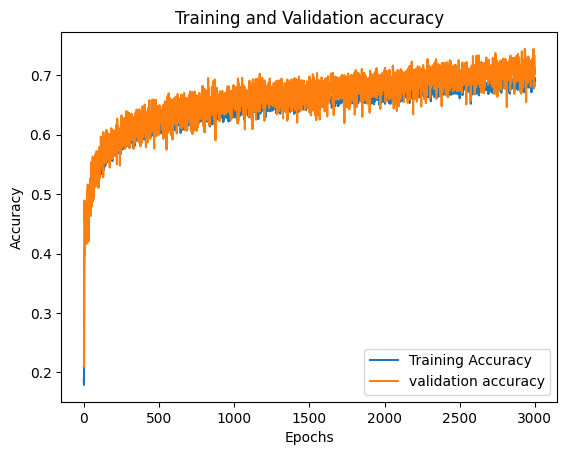

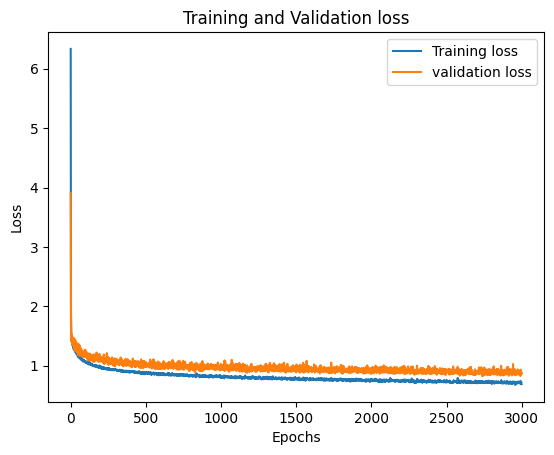

In [ ]:
plot_history(CNN_history)

#### Reshaping the test data so that we can test we could test the trained CNN on it

In [ ]:
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
X_test_reshaped.shape

(3573, 20, 128, 1)

#### Making predictions on the test data

In [ ]:
CNN_y_pred = np.argmax(CNN_model.predict(X_test_reshaped), axis = -1)
CNN_y_pred

112/112 [==============================] - 7s 3ms/step


array([4, 4, 4, ..., 0, 0, 0])

#### Calling the display_classification report function to show the classification report and the confusion matrix of the VGGish-CNN on the test data

              precision    recall  f1-score   support

           0     0.6270    0.8778    0.7315        90
           1     0.4954    0.7698    0.6028       139
           2     0.5495    0.7311    0.6275       569
           3     0.4505    0.7441    0.5612       508
           4     0.9065    0.5766    0.7048      1698
           5     0.9712    0.9473    0.9591       569

    accuracy                         0.6991      3573
   macro avg     0.6667    0.7744    0.6978      3573
weighted avg     0.7721    0.6991    0.7093      3573



<Figure size 2000x3000 with 0 Axes>

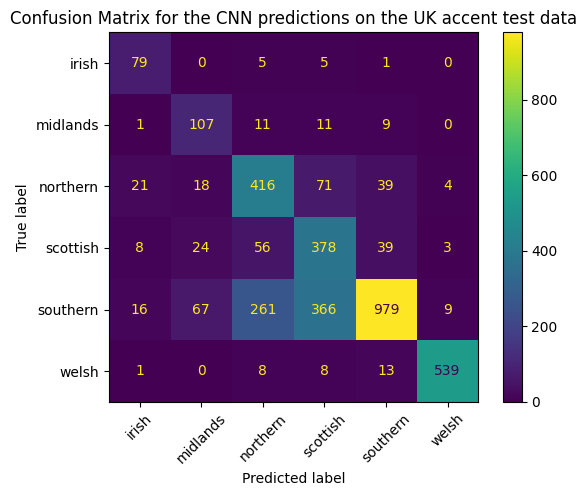

In [ ]:
display_classification_report(y_test, CNN_y_pred, "CNN", class_names)

#### Testing the VGGish-CNN model on a single prediction

In [ ]:
single_prediction("/content/drive/MyDrive/Accent Detection/Data/train/midlands/mif_02484_00326352632.wav", 3, CNN_model, "midlands")

1/1 [==============================] - 0s 195ms/step


{'Prediction': 'midlands',
 'confidence_levels':       class  Confidence level
 0     irish              0.00
 1  midlands             97.10
 2  northern              0.02
 3  scottish              0.05
 4  southern              2.81
 5     welsh              0.02,
 'play_audio': <pydub.audio_segment.AudioSegment at 0x7b086e25ea10>}

## Building a LSTM to classify on the VGGish embeddings

In [ ]:
tf.keras.backend.clear_session()
LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=0., input_shape = (X_train.shape[1], X_train.shape[2])),

    tf.keras.layers.LSTM(256, return_sequences = True, kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.LSTM(256, return_sequences = True, kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.LSTM(128, kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),

    # Dense layer
    tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(256, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(64, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    # Output layer
    tf.keras.layers.Dense(6, activation = "softmax")
])

#### Compiling the LSTM
+ We found the optimal parametes for the vggish-LSTM to be training an ADAM optimizer with a learning rate of 0.00005, and a categoricalcrossentropy loss function

In [ ]:
LSTM_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ["accuracy"]
              )

LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 20, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 20, 256)           394240    
                                                                 
 dropout (Dropout)           (None, 20, 256)           0         
                                                                 
 batch_normalization (Batch  (None, 20, 256)           1024      
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 20, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (None, 20, 256)           0         
                                                        

#### Training the VGGish-LSTM
+ we found that the model trained optimally with a batchsize of 256 and it converged at the 3000th epoch

In [ ]:
with tf.device('/GPU:0'):
  LSTM_history = LSTM_model.fit(X_train, tf.keras.utils.to_categorical(y_train),
                      validation_data = (X_val, tf.keras.utils.to_categorical(y_val)),
                      epochs = 3000,
                      batch_size = 256,
                      class_weight = class_weights)

Streaming output truncated to the last 5000 lines.
45/45 [==============================] - 1s 25ms/step - loss: 0.5906 - accuracy: 0.8004 - val_loss: 0.7088 - val_accuracy: 0.8120
Epoch 502/3000
45/45 [==============================] - 1s 25ms/step - loss: 0.5939 - accuracy: 0.7995 - val_loss: 0.7288 - val_accuracy: 0.8095
Epoch 503/3000
45/45 [==============================] - 1s 25ms/step - loss: 0.5918 - accuracy: 0.8050 - val_loss: 0.7417 - val_accuracy: 0.7938
Epoch 504/3000
45/45 [==============================] - 1s 26ms/step - loss: 0.5762 - accuracy: 0.8084 - val_loss: 0.7627 - val_accuracy: 0.7875
Epoch 505/3000
45/45 [==============================] - 1s 25ms/step - loss: 0.5771 - accuracy: 0.8071 - val_loss: 0.8020 - val_accuracy: 0.7899
Epoch 506/3000
45/45 [==============================] - 1s 26ms/step - loss: 0.5922 - accuracy: 0.8027 - val_loss: 0.7626 - val_accuracy: 0.7906
Epoch 507/3000
45/45 [==============================] - 1s 26ms/step - loss: 0.5783 - accuracy

#### Saving the VGGish-LSTM model to pickle

In [ ]:
save_to_pickle(pickle_prepared_model_path, "vggish_LSTM_main", [LSTM_model, LSTM_history])

#### Loading thr VGGish-LSTM from pickle

In [ ]:
LSTM = read_pickle(pickle_prepared_model_path, "vggish_LSTM_main.pkl")
LSTM_model = LSTM[0]
LSTM_history = LSTM[1]

#### Plotting the training and validation loss and accuracy for the VGGish - LSTM model

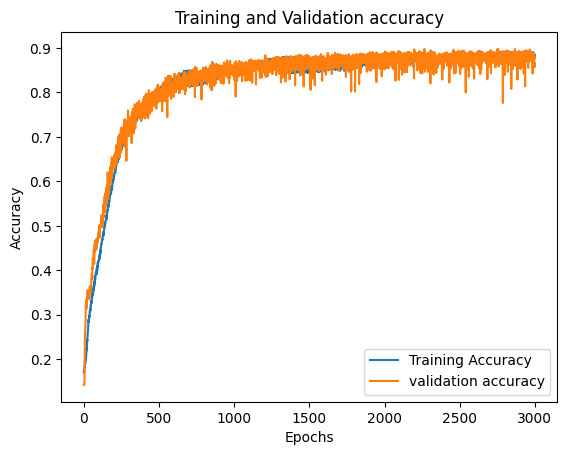

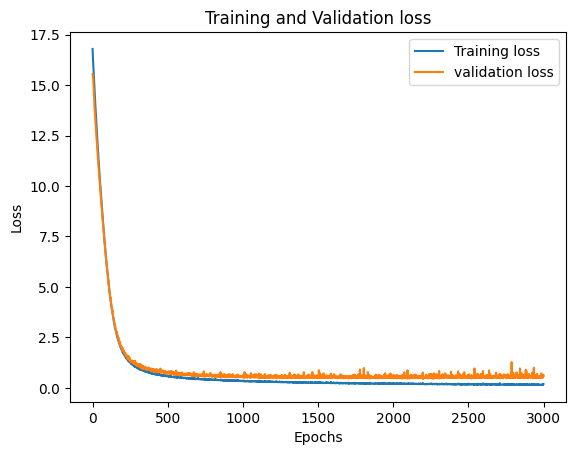

In [ ]:
plot_history(LSTM_history)

In [ ]:
LSTM_history

In [ ]:
LSTM_y_pred = np.argmax(LSTM_model.predict(X_test), axis = -1)
LSTM_y_pred

112/112 [==============================] - 5s 5ms/step


array([4, 4, 4, ..., 0, 0, 0])

#### Diplaying the classification report and the confusion matrix of the VGGish - LSTM model

              precision    recall  f1-score   support

           0     0.9000    0.9000    0.9000        90
           1     0.8636    0.8201    0.8413       139
           2     0.8066    0.8576    0.8313       569
           3     0.6627    0.8701    0.7523       508
           4     0.9401    0.8316    0.8825      1698
           5     0.9688    0.9824    0.9756       569

    accuracy                         0.8665      3573
   macro avg     0.8570    0.8770    0.8638      3573
weighted avg     0.8800    0.8665    0.8695      3573



<Figure size 2000x3000 with 0 Axes>

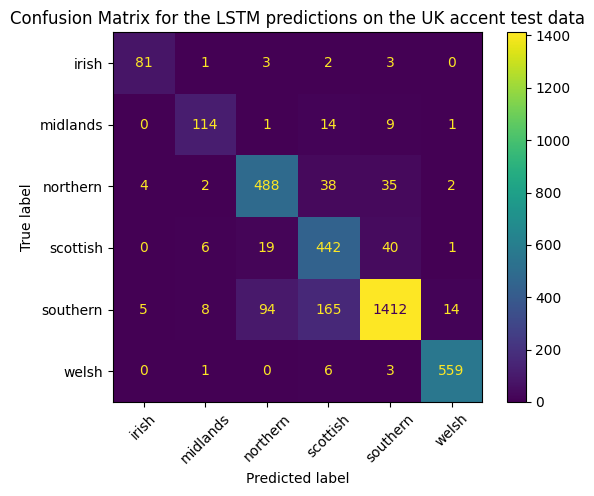

In [ ]:
display_classification_report(y_test, LSTM_y_pred, "LSTM", class_names)

#### Testing a single prediction for the vggish - LSTM model

In [ ]:
single_prediction("/content/drive/MyDrive/Accent Detection/Data/train/midlands/mif_02484_00326352632.wav", 2, LSTM_model, "midlands")

1/1 [==============================] - 0s 25ms/step


{'Prediction': 'midlands',
 'confidence_levels':       class  Confidence level
 0     irish               0.0
 1  midlands             100.0
 2  northern               0.0
 3  scottish               0.0
 4  southern               0.0
 5     welsh               0.0,
 'play_audio': <pydub.audio_segment.AudioSegment at 0x7b08a6920bb0>}

## Building an MLP to classify the vggish embeddings
+ The architecture included dropout and kernel reguralization to help tackle overfitting

In [ ]:
tf.keras.backend.clear_session()

MLP_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]), name="embedding"),

    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5, name="dropout_1"),

    tf.keras.layers.Dense(384, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2, name="dropout_2"),

    tf.keras.layers.Dense(192, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.6, name="dropout_3"),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(384, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2, name="dropout_4"),
    tf.keras.layers.Dense(6, activation='softmax')

])

MLP_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20, 256)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 20, 256)           0         
                                                                 
 dense_1 (Dense)             (None, 20, 384)           98688     
                                                                 
 dropout_2 (Dropout)         (None, 20, 384)           0         
                                                                 
 dense_2 (Dense)             (None, 20, 192)           73920     
                                                                 
 dropout_3 (Dropout)         (None, 20, 192)           0         
                                                                 
 flatten (Flatten)           (None, 3840)              0

#### Compiling the MLP model
+ We found that compiling the model with the Adam optimizer with a learning rate of 0.000005 and the categorical cross entropy loss proved to be optimal

In [ ]:
MLP_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000005),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ["accuracy"]
              )

#### Training the MLP model
+ The model converged at 50,000 epochs using a batch size of 256 and class weights to handle imbalance

In [ ]:

with tf.device('/GPU:0'):
  MLP_history = MLP_model.fit(
      X_train, keras.utils.to_categorical(y_train), batch_size = 256,
      epochs = 50000, verbose = 1,
      validation_data = (X_val, keras.utils.to_categorical(y_val)),
      class_weight = class_weights
  )

Streaming output truncated to the last 5000 lines.
45/45 [==============================] - 0s 9ms/step - loss: 0.5058 - accuracy: 0.8401 - val_loss: 0.6859 - val_accuracy: 0.8235
Epoch 47502/50000
45/45 [==============================] - 0s 9ms/step - loss: 0.5076 - accuracy: 0.8354 - val_loss: 0.6761 - val_accuracy: 0.8315
Epoch 47503/50000
45/45 [==============================] - 0s 8ms/step - loss: 0.5068 - accuracy: 0.8389 - val_loss: 0.6790 - val_accuracy: 0.8284
Epoch 47504/50000
45/45 [==============================] - 0s 9ms/step - loss: 0.5052 - accuracy: 0.8397 - val_loss: 0.7088 - val_accuracy: 0.8151
Epoch 47505/50000
45/45 [==============================] - 0s 9ms/step - loss: 0.5084 - accuracy: 0.8400 - val_loss: 0.6835 - val_accuracy: 0.8256
Epoch 47506/50000
45/45 [==============================] - 0s 9ms/step - loss: 0.5095 - accuracy: 0.8380 - val_loss: 0.6921 - val_accuracy: 0.8207
Epoch 47507/50000
45/45 [==============================] - 0s 9ms/step - loss: 0.5083

#### saving the VGGish-MLP model to a pickle object

In [ ]:
save_to_pickle(pickle_prepared_model_path, "vggish_MLP", [MLP_model, MLP_history])

#### Reading the VGGish-MLP model from its pickle path

In [ ]:
MLP = read_pickle(pickle_prepared_model_path, "vggish_MLP.pkl")
MLP_model = MLP[0]
MLP_history = MLP[1]

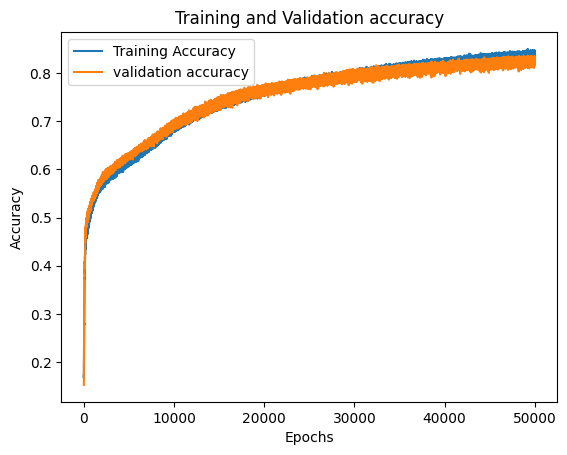

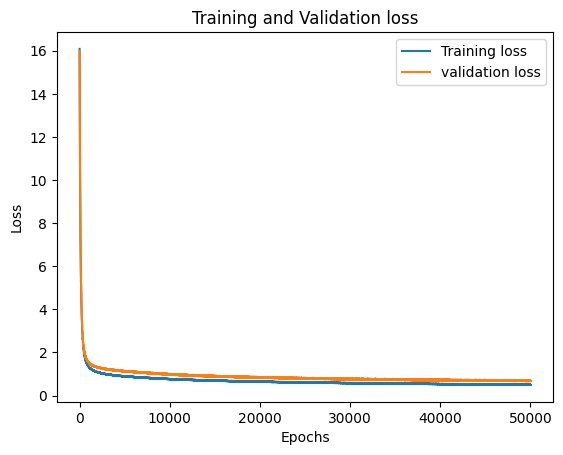

In [ ]:
plot_history(MLP_history)

#### Making predictions on the test set using the VGGish-MLP

In [ ]:
MLP_y_pred = np.argmax(MLP_model.predict(X_test), axis = -1)
MLP_y_pred

112/112 [==============================] - 0s 3ms/step


array([4, 4, 4, ..., 0, 0, 0])

#### Displaying the classification report and the confusion matrix for the VGGish MLP model

              precision    recall  f1-score   support

           0     0.8283    0.9111    0.8677        90
           1     0.5902    0.8705    0.7035       139
           2     0.7020    0.8155    0.7545       569
           3     0.6402    0.8406    0.7268       508
           4     0.9291    0.7562    0.8338      1698
           5     0.9911    0.9736    0.9823       569

    accuracy                         0.8206      3573
   macro avg     0.7801    0.8612    0.8114      3573
weighted avg     0.8460    0.8206    0.8254      3573



<Figure size 2000x3000 with 0 Axes>

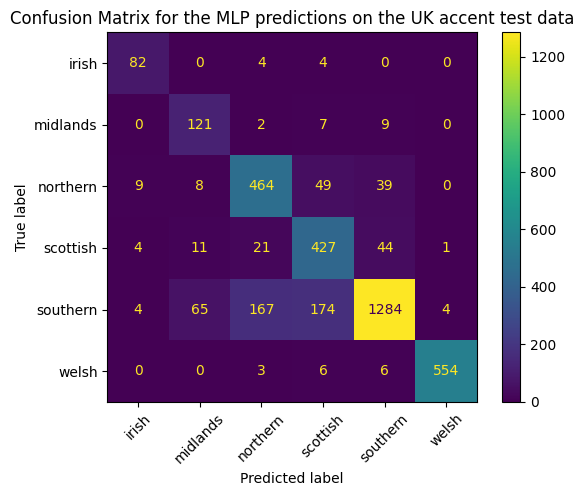

In [ ]:
display_classification_report(y_test, MLP_y_pred, "MLP", class_names)